<a href="https://colab.research.google.com/github/Prachi729/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [ ]:
TESS='/content/drive/MyDrive/TESS'

In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk(TESS):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())


print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
len(paths)

2775

In [ ]:
paths[:5]

['/content/drive/MyDrive/TESS/YAF_pleasant_surprised/YAF_beg_ps.wav',
 '/content/drive/MyDrive/TESS/YAF_pleasant_surprised/YAF_back_ps.wav',
 '/content/drive/MyDrive/TESS/YAF_pleasant_surprised/YAF_bean_ps.wav',
 '/content/drive/MyDrive/TESS/YAF_pleasant_surprised/YAF_bath_ps.wav',
 '/content/drive/MyDrive/TESS/YAF_pleasant_surprised/YAF_bar_ps.wav']

In [ ]:
labels[:5]

['ps', 'ps', 'ps', 'ps', 'ps']

In [ ]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/TESS/YAF_pleasant_surpr...,ps
1,/content/drive/MyDrive/TESS/YAF_pleasant_surpr...,ps
2,/content/drive/MyDrive/TESS/YAF_pleasant_surpr...,ps
3,/content/drive/MyDrive/TESS/YAF_pleasant_surpr...,ps
4,/content/drive/MyDrive/TESS/YAF_pleasant_surpr...,ps


In [ ]:
df['label'].value_counts()

,count
label,
ps,400
fear,400
sad,400
disgust,400
neutral,400
happy,400
angry,375


<Axes: xlabel='label', ylabel='count'>

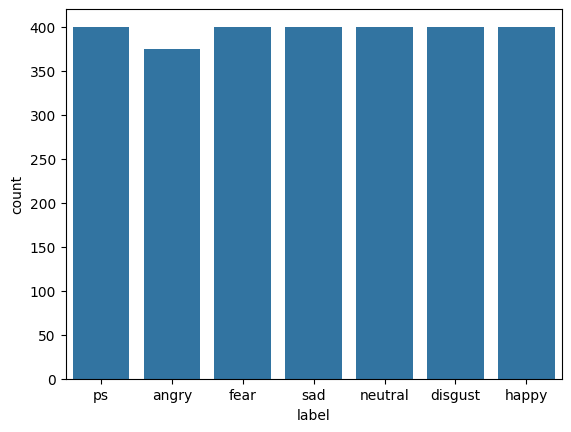

In [ ]:
sns.countplot(data=df, x='label')

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

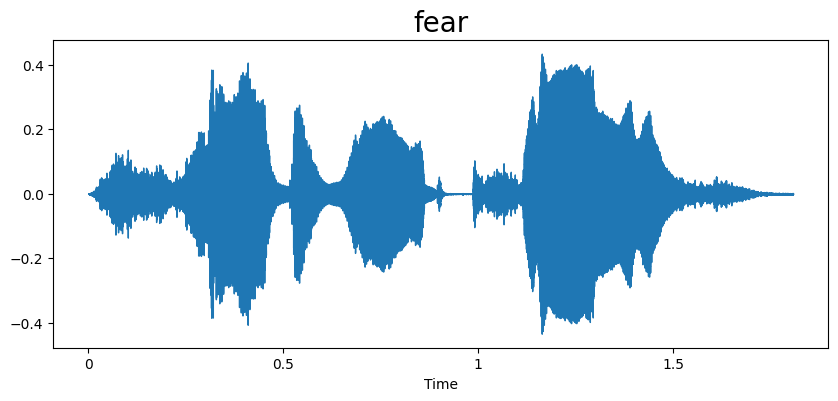

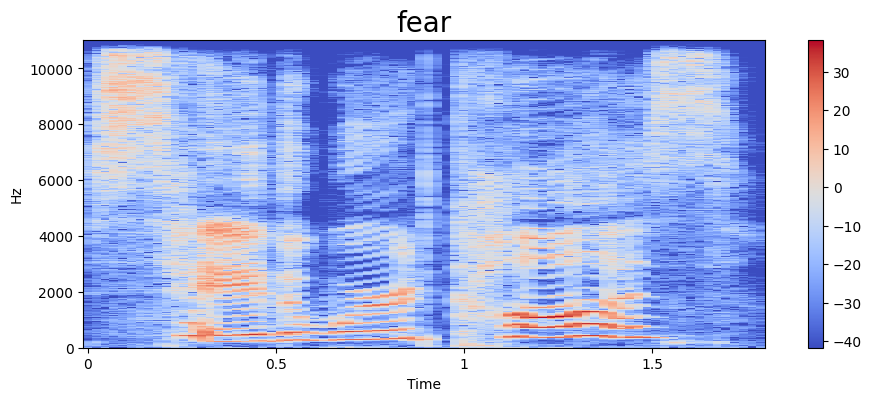

In [ ]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


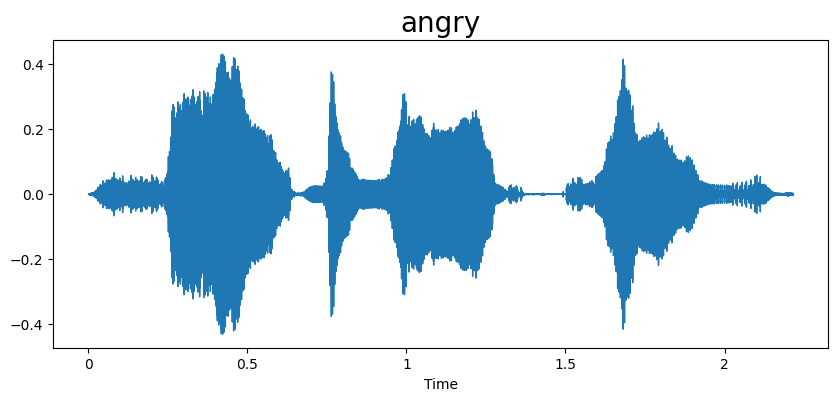

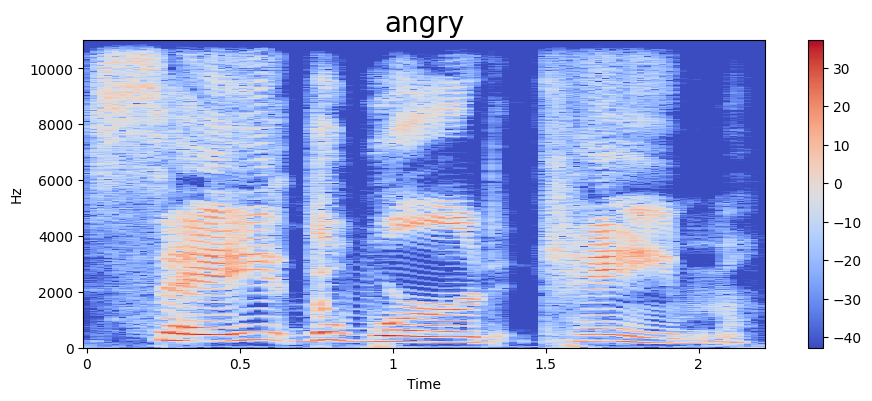

In [ ]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

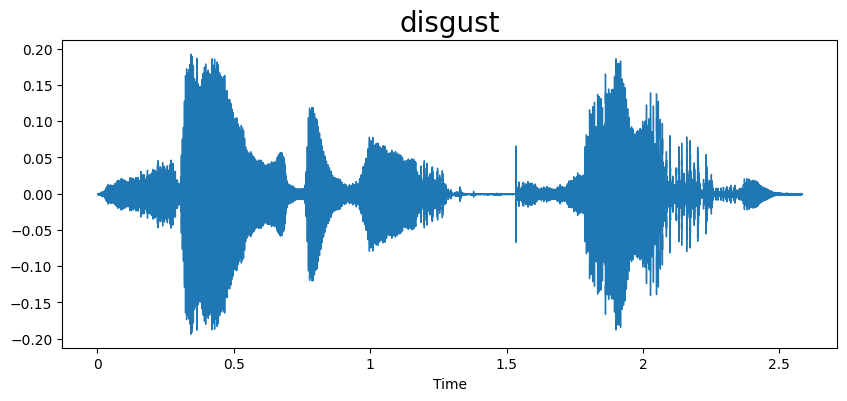

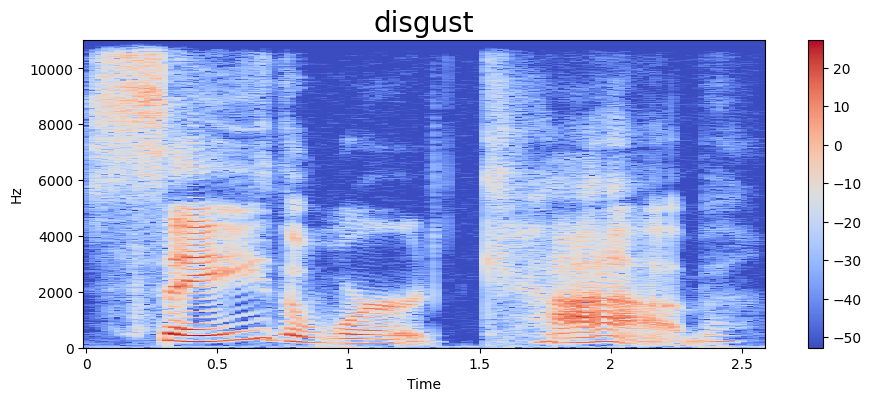

In [ ]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

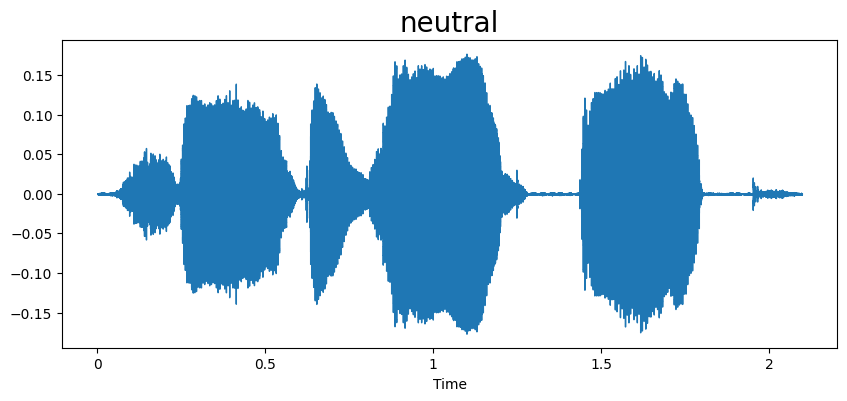

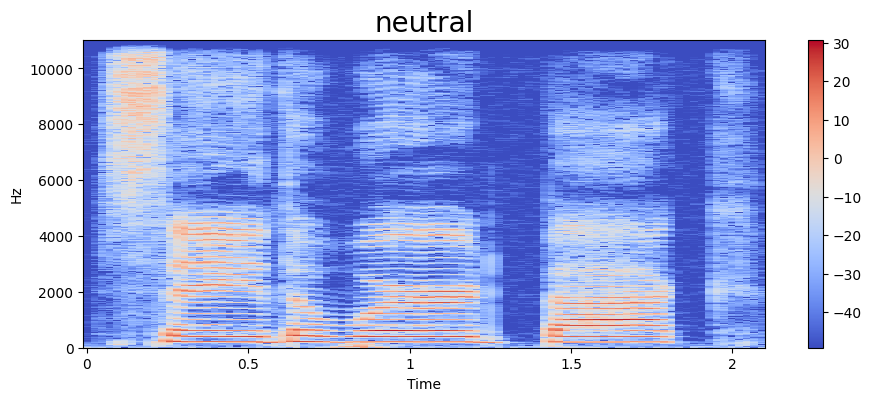

In [ ]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

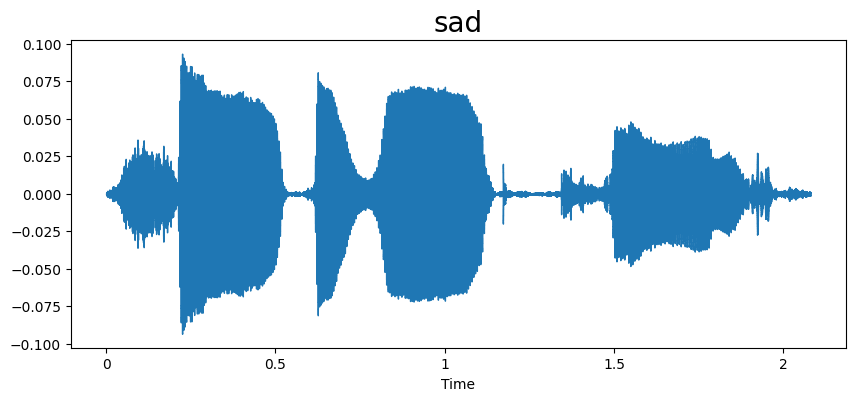

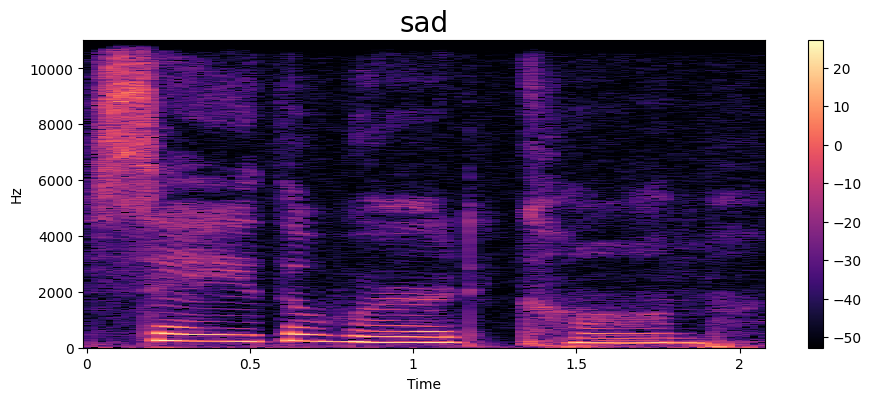

In [ ]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

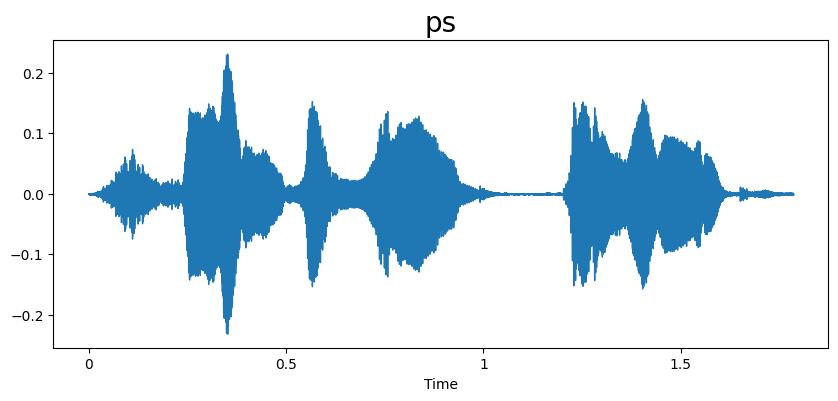

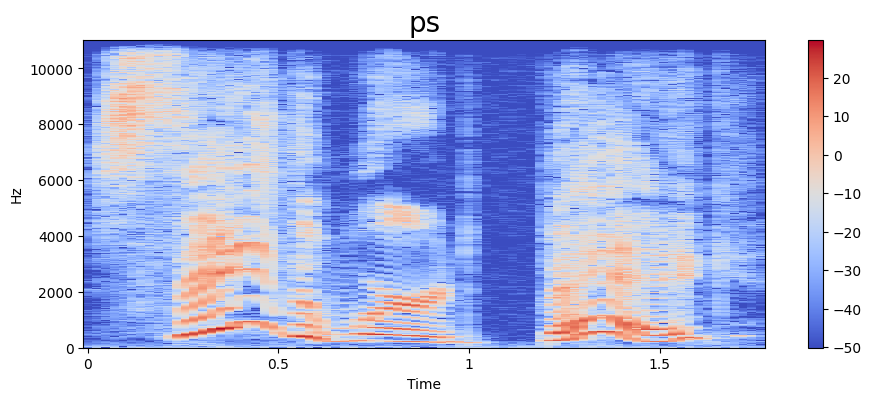

In [ ]:
emotion = 'ps'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

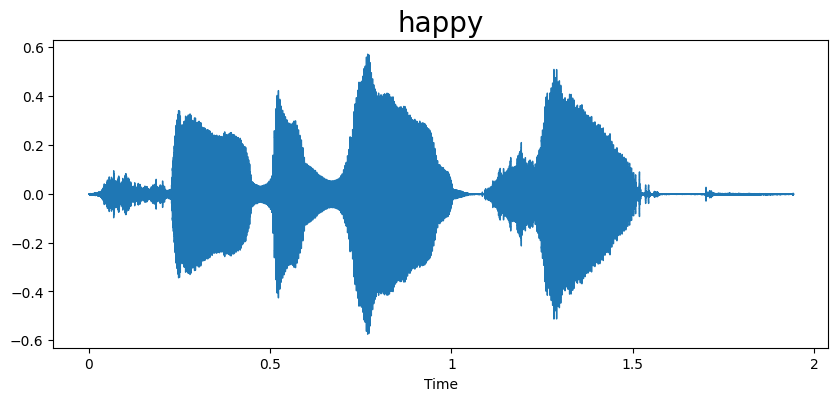

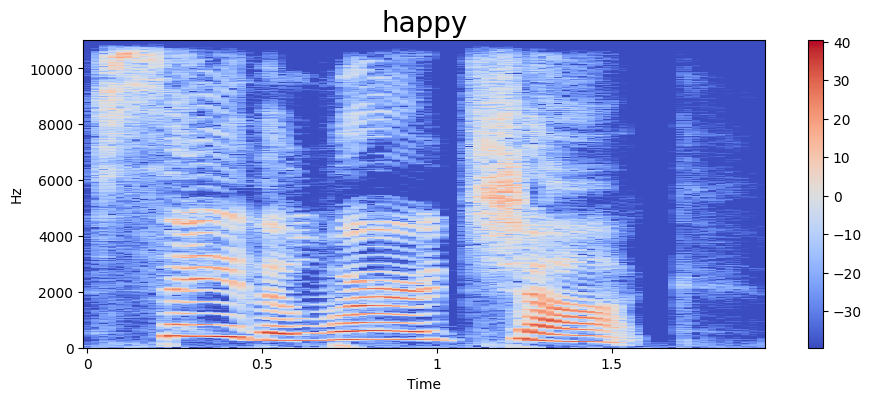

In [ ]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
inverse_label_map ={idx:label for label, idx in label_map.items()}
df['labels'] = df['label'].map(label_map)
df.head(2)

,speech,label,labels
0,/content/drive/MyDrive/TESS/YAF_pleasant_surpr...,ps,0
1,/content/drive/MyDrive/TESS/YAF_pleasant_surpr...,ps,0


In [ ]:
class Speech_Emotion_Dataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['speech']
        label = self.df.iloc[idx]['labels']

        # Load audio file
        speech, sr = librosa.load(audio_path, sr=16000)

        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        inputs = self.processor(speech, sampling_rate=sr, return_tensors="pt", padding=True, truncate=True, max_length=self.max_length)
        input_values= inputs.input_values.squeeze()
        return {'input_values':input_values,'labels':torch.tensor(label, dtype=torch.long)}

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = Speech_Emotion_Dataset(train_df, processor)
test_dataset = Speech_Emotion_Dataset(test_df, processor)


In [ ]:
train_dataset[0]['input_values'].size()

Keyword argument `truncate` is not a valid argument for this processor and will be ignored.


torch.Size([32000])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return{
       "accuracy": accuracy,
       "precision": precision,
       "recall": recall,
       "f1": f1
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.710874,0.983784,0.985089,0.983784,0.983772
2,No log,0.257758,0.990991,0.991262,0.990991,0.990992
3,No log,0.173461,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=417, training_loss=0.6849520383693045, metrics={'train_runtime': 2454.6161, 'train_samples_per_second': 2.713, 'train_steps_per_second': 0.17, 'total_flos': 1.2092902992e+17, 'train_loss': 0.6849520383693045, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.1734611988067627, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 8.2924, 'eval_samples_per_second': 66.929, 'eval_steps_per_second': 4.221, 'epoch': 3.0}


In [ ]:
from IPython.display import Audio, display
import random
import numpy as np
from scipy.special import softmax

# Get predictions from the trainer
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids
true_emotions = [inverse_label_map[label] for label in true_labels]
pred_emotions = [inverse_label_map[label] for label in pred_labels]

# Sample 10 random validation examples
num_samples = 10
sample_indices = random.sample(range(len(test_dataset)), num_samples)

print("=== Sample Predictions (True vs. Predicted) ===")
for idx in sample_indices:
    true_emo = true_emotions[idx]
    pred_emo = pred_emotions[idx]
    is_correct = true_emo == pred_emo
    confidence = np.max(softmax(predictions.predictions[idx], axis=0))
    # Access the audio path from the original test_df using the index
    audio_path = test_dataset.df.iloc[idx]['speech']


    status = "✓ Correct" if is_correct else "✗ Wrong"
    print(f"Sample {idx+1}: True={true_emo}, Pred={pred_emo} ({status}, Conf: {confidence:.3f})")
    print(f"Audio: {os.path.basename(audio_path)}")

    # Play audio (uncomment to hear)
    # display(Audio(audio_path, autoplay=False))
    print("---")

=== Sample Predictions (True vs. Predicted) ===
Sample 285: True=ps, Pred=ps (✓ Correct, Conf: 0.804)
Audio: YAF_rough_ps.wav
---
Sample 7: True=sad, Pred=sad (✓ Correct, Conf: 0.832)
Audio: OAF_pearl_sad.wav
---
Sample 164: True=fear, Pred=fear (✓ Correct, Conf: 0.867)
Audio: OAF_cab_fear.wav
---
Sample 433: True=angry, Pred=angry (✓ Correct, Conf: 0.845)
Audio: YAF_chain_angry.wav
---
Sample 349: True=happy, Pred=happy (✓ Correct, Conf: 0.821)
Audio: OAF_tool_happy.wav
---
Sample 160: True=ps, Pred=ps (✓ Correct, Conf: 0.804)
Audio: YAF_long_ps.wav
---
Sample 221: True=fear, Pred=fear (✓ Correct, Conf: 0.865)
Audio: OAF_love_fear.wav
---
Sample 345: True=neutral, Pred=neutral (✓ Correct, Conf: 0.862)
Audio: OAF_vote_neutral.wav
---
Sample 105: True=disgust, Pred=disgust (✓ Correct, Conf: 0.855)
Audio: YAF_sour_disgust.wav
---
Sample 95: True=sad, Pred=sad (✓ Correct, Conf: 0.832)
Audio: OAF_germ_sad.wav
---
